In [96]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
import statsmodels.api as sm


In [97]:
#dfStats = gp.read_file("regression_results/ols_run_tdx2.gpkg")
#dfStats = gp.read_file("regression_results/test.gpkg")
rivers = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/rivers_reprojected.shp")
countries = gp.read_file("/data/puma1/scratch/mtngla/background-shapefiles/countries.shp")

In [98]:
environmentName = 'DEVv2'
# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'ReadyHim2'
runName='RunHim2'
region='himalayas'
size = 100000

query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

bbx = query.getDataSetBoundingBox( parentDsName, dataset, region)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":-1600000,"gridCellMaxX":1400000,"gridCellMinY":-1000000,"gridCellMaxY":800000,"minTime":1279266673,"maxTime":1556338066,"totalPoints":4045536,"numberOfShards":259}


In [99]:
stats = query.getRunStatistics(parentDsName, runName)
stats = json.loads(stats)
dfStats = json_normalize(stats)
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue1,statistics.pointsOnDataSetValue1Ratio,statistics.pointsOnDataSetValue2,...,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered
0,-1600000,-100000,100000,0.86,3.40,106,-22.42,10.00,9.43,96,...,-35.16,0.00,-29.75,-9.82,-11.18,-21.18,-5.34,-7.11,106,208320
1,-1500000,0,100000,0.22,0.75,6,-10.26,nan,nan,6,...,-19.61,-7.95,0.00,0.00,0.00,0.00,0.00,0.00,6,107482
2,-1500000,400000,100000,10.77,107.07,2474,-13.66,434.00,17.54,2040,...,-3.67,-24.36,-14.09,-6.70,-30.27,-26.03,-5.27,-37.99,2474,238435
3,-1400000,0,100000,23.88,63.41,2252,-10.61,149.00,6.62,2103,...,-8.08,-12.64,-8.08,-12.02,-11.92,-5.54,-17.56,-12.09,2252,99643
4,-1400000,100000,100000,2.37,11.98,159,-17.11,13.00,8.18,146,...,-14.21,-15.77,-22.85,-17.72,-24.62,0.00,-22.86,8.90,159,458879


In [100]:
pd.options.display.float_format = '{:20,.2f}'.format
dfStats.sum()

gridCell.minX                                 -16,100,000.00
gridCell.minY                                 -59,400,000.00
gridCell.size                                  25,900,000.00
statistics.DebrisMaskArea                           9,636.41
statistics.GlacierMaskArea                         89,636.96
statistics.afterGlacierMask                     4,045,536.00
statistics.meanElevationDifference                 -2,179.93
statistics.pointsOnDataSetValue1                  361,837.00
statistics.pointsOnDataSetValue1Ratio               3,471.80
statistics.pointsOnDataSetValue2                3,683,699.00
statistics.pointsOnDataSetValue2Ratio              22,428.20
statistics.pointsWithinDebrisMask                 137,719.00
statistics.result_avgX                         -3,261,483.57
statistics.result_avgY                        -45,968,327.08
statistics.result_count_2010                      136,682.00
statistics.result_count_2011                      446,782.00
statistics.result_count_

In [102]:
print('TDX: ',dfStats['statistics.pointsOnDataSetValue2'].sum()/dfStats['statistics.result_total'].sum()*100)
print('SRTM: ',dfStats['statistics.pointsOnDataSetValue1'].sum()/dfStats['statistics.result_total'].sum()*100)

TDX:  91.05589469479446
SRTM:  8.944105305205541


In [101]:
dfStats.shape[0]

259

In [15]:
dfStats.head()

,gridCell.minX,gridCell.minY,gridCell.size,statistics.DebrisMaskArea,statistics.GlacierMaskArea,statistics.afterGlacierMask,statistics.meanElevationDifference,statistics.pointsOnDataSetValue1,statistics.pointsOnDataSetValue1Ratio,statistics.pointsOnDataSetValue2,...,statistics.result_refDifference_2012,statistics.result_refDifference_2013,statistics.result_refDifference_2014,statistics.result_refDifference_2015,statistics.result_refDifference_2016,statistics.result_refDifference_2017,statistics.result_refDifference_2018,statistics.result_refDifference_2019,statistics.result_total,statistics.tdx2_filtered
0,-1600000,-100000,100000,0.86,3.40,106,-22.42,10.00,9.43,96,...,-35.16,0.00,-29.75,-9.82,-11.18,-21.18,-5.34,-7.11,106,208320
1,-1500000,0,100000,0.22,0.75,6,-10.26,nan,nan,6,...,-19.61,-7.95,0.00,0.00,0.00,0.00,0.00,0.00,6,107482
2,-1500000,400000,100000,10.77,107.07,2474,-13.66,434.00,17.54,2040,...,-3.67,-24.36,-14.09,-6.70,-30.27,-26.03,-5.27,-37.99,2474,238435
3,-1400000,0,100000,23.88,63.41,2252,-10.61,149.00,6.62,2103,...,-8.08,-12.64,-8.08,-12.02,-11.92,-5.54,-17.56,-12.09,2252,99643
4,-1400000,100000,100000,2.37,11.98,159,-17.11,13.00,8.18,146,...,-14.21,-15.77,-22.85,-17.72,-24.62,0.00,-22.86,8.90,159,458879


In [103]:
crs = json.loads(query.getProjection(parentDsName, region))['proj4']

def toGeoData(data):
    # Convert gridcells to point geometries in the middle of the cell
    geometry = [Point(xy) for xy in zip(data['gridCell.minX']+(size/2), data['gridCell.minY']+(size/2))]
    gData = gp.GeoDataFrame(data, crs=crs, geometry=geometry)
    return gData

dfStats = toGeoData(dfStats.copy())

In [107]:
#%matplotlib notebook
#plt.hist(x=dfStats['statistics.GlacierMaskArea'], bins=50)
dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

<IPython.core.display.Javascript object>


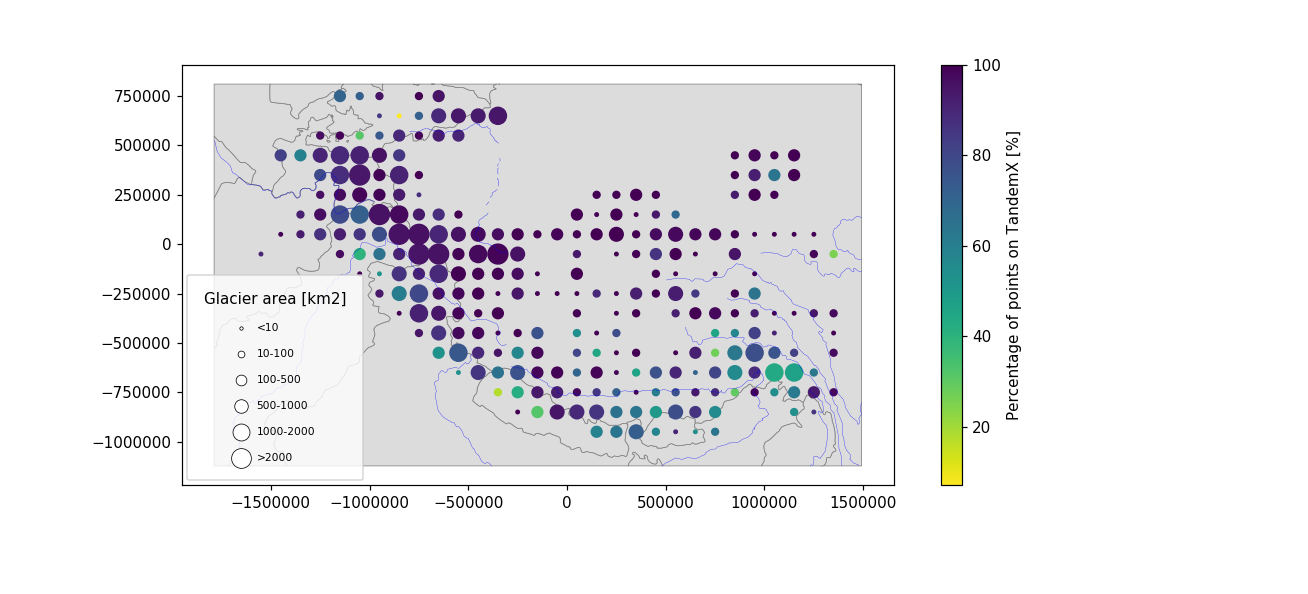

In [109]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(11,5))


# plot rivers and country boundaries
countries.plot(ax=ax, edgecolor='grey', color='gainsboro', linewidth=0.5)
rivers.plot(ax=ax, edgecolor='blue', linewidth=0.2)

cmap='viridis_r'
vmin=dfStats['statistics.pointsOnDataSetValue2Ratio'].min()
vmax=dfStats['statistics.pointsOnDataSetValue2Ratio'].max()

markersize = dfStats['statistics.GlacierMaskArea.pointsize']
plot = dfStats.plot(ax=ax, column='statistics.pointsOnDataSetValue2Ratio', markersize=markersize, cmap=cmap, \
                   vmin=vmin, vmax=vmax)

labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]
markers=[]
for size in sizes:
    markers.append(plt.scatter([],[], s=size, label=size, color='white', edgecolor='black', linewidth=0.5))

bar=fig.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap))
bar.set_label('Percentage of points on TandemX [%]')
    
plt.legend(handles=markers)
leg = plt.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 3, borderpad = 1.6,\
handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)


#for i, txt in enumerate(dfStats['statistics.result_total']):
#    ax.annotate(int(txt), (dfStats.loc[dfStats.index[i], 'gridCell.minX']+ \
#                               (size/2)+10000, dfStats.loc[dfStats.index[i], 'gridCell.minY']+\
#                               (size/2)+10000), fontsize=5)

<IPython.core.display.Javascript object>


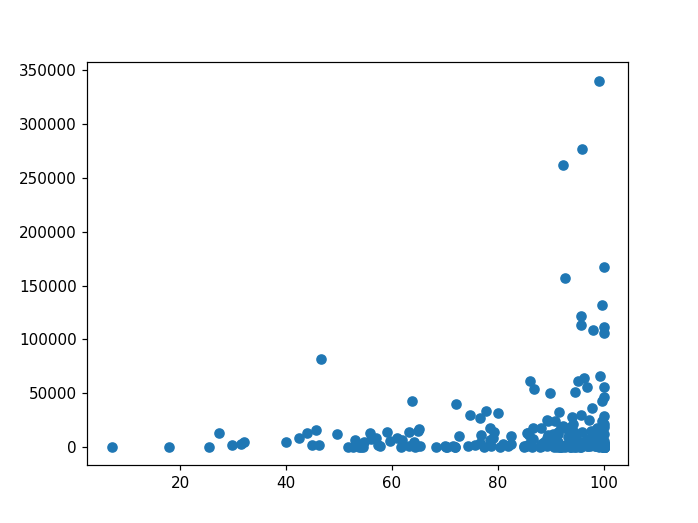

In [106]:
%matplotlib notebook
plt.scatter(x=dfStats['statistics.pointsOnDataSetValue2Ratio'], y=dfStats['statistics.result_total'])